# MATH70125 Market Microstructure
**Authors: X.Zhao, L.Jin and S.Wang**

# Config

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import expon, gamma, pareto, powerlaw
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [28]:
TOTAL_TIME = 32400
NUM_LEVELS = 5
TICK_SIZE = 0.01
INITIAL_MID_PRICE = 171.005
LEVEL_WEIGHTS = [0.5, 0.25, 0.1, 0.075, 0.075]
size_shape, size_scale = 2.5, 1.5/2.5
g_shape, g_scale = 5, 8

# Utilities

In [29]:
a1, b1, c1 = 64.459, 0.103, 4.932
a2, b2, c2 = 53.086, 0.110, 5.331
a3, b3, c3 = 4.900, 0.122, 0.145
a5, b5, c5 = 4.363, 0.502, 0.122

def l1(x):
    if x < 4:
        return 15 + x*18/4
    if x < 8:
        return 33
    return a1 * np.exp(-b1 * x) + c1
def l2(x):
    if x < 4:
        return 7 + 4*x
    if x < 9:
        return 26
    return a2 * np.exp(-b2 * x) + c2
def l3(x):
    return max(a3 * np.exp(-b3 * x) + c3, 0)
def l4(x):
    if x < 2.5:
        return (-1.3*x + 3.5)
    else:
        return (max(-0.1*x + 0.5, 0))
def l5(x):
    return (max(a5 * np.exp(-b5 * x) + c5, 0))

In [30]:
def initialize_lob():
    bid_queues = gamma.rvs(a=g_shape, scale=g_scale, size=NUM_LEVELS, random_state=42).tolist()
    ask_queues = gamma.rvs(a=g_shape, scale=g_scale, size=NUM_LEVELS, random_state=41).tolist()
    return bid_queues, ask_queues

In [31]:
def compute_stats(df):
    stats = {}
    for level in range(NUM_LEVELS):
        level_df = df[df['level'] == level]
        stats[level] = {
            '#L': len(level_df[level_df['type'] == 'L']),
            '#C': len(level_df[level_df['type'] == 'C']),
            '#M': len(level_df[level_df['type'] == 'M']),
            'AES': level_df['size'].mean(),
            'AIT': np.diff(level_df['time']).mean() * 1000 if len(level_df) > 1 else np.nan
        }
    
    unique_times = np.unique(df['time'])
    price_changes = np.diff(df['mid_price'].reindex(unique_times, method='ffill'))
    annualized_volatility = price_changes.std() * np.sqrt(252 * 32400)
    
    stats_df = pd.DataFrame(stats).T
    stats_df.loc['Volatility'] = np.nan
    stats_df.at['Volatility', 'Volatility'] = annualized_volatility
    
    return stats_df

# Baseline

In [32]:
def initialize_lob_b():
    bid_queues = gamma.rvs(a=2, scale=10, size=NUM_LEVELS).tolist()
    ask_queues = gamma.rvs(a=2, scale=10, size=NUM_LEVELS).tolist()
    bid_prices = [INITIAL_MID_PRICE - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
    ask_prices = [INITIAL_MID_PRICE + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
    return bid_queues, ask_queues, bid_prices, ask_prices

LAMBDA_GLOBAL = 40
INTRA_DAY_BOOST = {0: 1.0, 10800: 1.0, 21600: 1.0}
EVENT_PROBS = {'L': 0.45, 'C': 0.45, 'M': 0.10}

def simulate_lob_stylized_facts():
    bid_queues, ask_queues, bid_prices, ask_prices = initialize_lob_b()
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    prev_events = []
    lambda_entries = []

    while t < TOTAL_TIME:
        lambda_scale = 1.0
        for time, boost in INTRA_DAY_BOOST.items():
            if t >= time:
                lambda_scale = boost

        level = np.random.choice(range(NUM_LEVELS), p=LEVEL_WEIGHTS)
        side = np.random.choice(['bid', 'ask'])
        queues = bid_queues if side == 'bid' else ask_queues
        prices = bid_prices if side == 'bid' else ask_prices
        q_before = queues[level]

        lambda_global_adjusted = LAMBDA_GLOBAL * lambda_scale

        excitation = 0
        for prev_t, prev_type in prev_events[-10:]:
            dt = t - prev_t
            if dt > 0:
                excitation += 0.5 * np.exp(-0.05 * dt)
        lambda_global_final = max(0.1, lambda_global_adjusted + excitation)

        dt = expon.rvs(scale=1/lambda_global_final)
        t += dt

        lambda_entries.append({
            'time': t,
            'lambda': lambda_global_final
        })


        if t > TOTAL_TIME:
            break

        event_type = np.random.choice(['L', 'C', 'M'], p=[EVENT_PROBS['L'], EVENT_PROBS['C'], EVENT_PROBS['M']])

        size = powerlaw.rvs(2.5, loc=1, scale=30, size=1)[0]
        #size = max(1, min(30, size))
        #size = pareto.rvs(2.5, scale=1.5/2.5)

        if event_type == 'L':
            queues[level] += size
        elif event_type == 'C' and q_before > 0:
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
        elif event_type == 'M':
            opp_queues = ask_queues if side == 'bid' else bid_queues
            if opp_queues[0] > 0:
                rem_size = size
                while rem_size > 0 and opp_queues:
                    available = opp_queues[0]
                    if rem_size < available:
                        opp_queues[0] -= rem_size
                        rem_size = 0
                    else:
                        rem_size -= available
                        opp_queues[0] = 0
                        
                        if np.random.random() < 0.7:
                            if side == 'bid':
                                mid_price = mid_price + 0.5 * TICK_SIZE
                            else:
                                mid_price = mid_price - 0.5 * TICK_SIZE
                            if side == 'bid':
                                ask_prices = [mid_price + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                            else:
                                bid_prices = [mid_price - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                        # 在原地补充被耗尽的订单（基于gamma分布）
                        opp_queues[0] = gamma.rvs(a=2, scale=10)

        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level + 1,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
        prev_events.append((t, event_type))
        if len(prev_events) > 100:
            prev_events.pop(0)

    lambda_entries = pd.DataFrame(lambda_entries)

    return pd.DataFrame(events)

# QR

In [101]:
class OrderBookIntensity:
    def __init__(self, bid_queues, ask_queues):
        self.intensity = {}
        self.global_lambda=0
        self.initialize(bid_queues, ask_queues)
        
    def _scale(self, base, level):
        return base * (LEVEL_WEIGHTS[level] / LEVEL_WEIGHTS[0])

    def _compute_intensity(self, side, level_index, queue_size):
        limit_lambda = l1(queue_size)
        cancel_lambda = l2(queue_size)

        if level_index == 0:
            market_lambda = l3(queue_size)
        else:
            market_lambda = 0

        return [
            self._scale(limit_lambda, level_index),
            self._scale(cancel_lambda, level_index),
            self._scale(market_lambda, level_index)
        ]
    
    def initialize(self, bid_queues, ask_queues):
        for level, queue_size in enumerate(bid_queues):
            self.update("bid", level, queue_size)

        for level, queue_size in enumerate(ask_queues):
            self.update("ask", level, queue_size)
        
    def update(self, side, level, queue_size):
        self.intensity[f"{side}{level}"] = self._compute_intensity(side, level, queue_size)
        self._update_global_lambda()
    
    def _update_global_lambda(self):
        self.global_lambda = sum(sum(lambdas) for lambdas in self.intensity.values())   
        
    def sample_next_event(self):
        side = random.choice(["bid", "ask"])
        level = np.random.choice(range(5), p=LEVEL_WEIGHTS)

        key = f"{side}{level}"
        lambdas = self.intensity[key]
        event_type = random.choices(
            ["L", "C", "M"],
            weights=lambdas,
            k=1
        )[0]
        
        size = pareto.rvs(size_shape, scale=size_scale)
        #dt = expon.rvs(scale=1/40)
        dt = expon.rvs(scale=1/(self.global_lambda))
        return side, level, event_type, size, dt

In [36]:
def simulate_qr():
    bid_queues, ask_queues = initialize_lob()
    OBI = OrderBookIntensity(bid_queues, ask_queues)
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating QR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:
        side, level, event_type, size, dt = OBI.sample_next_event()
        queues = bid_queues if side == 'bid' else ask_queues
        q_before = queues[level]
        
        t += dt
        progress_bar.update(dt)
        if t > TOTAL_TIME:
            break
            
        if event_type == 'L':
            queues[level] += size
            OBI.update(side, level, queues[level])
            
        elif event_type == 'C':
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
            OBI.update(side, level, queues[level])
            
            if queues[0] == 0:
                opp_queues = ask_queues if side == 'bid' else bid_queues
                if np.random.random() < 0.7:
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    opp_queues.pop()
                    
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                    
                    for lvl in range(5):
                        OBI.update("bid", lvl, bid_queues[lvl])
                        OBI.update("ask", lvl, ask_queues[lvl])
                else:
                    queues[0] = gamma.rvs(a=2, scale=10)
                    OBI.update(side, 0, queues[0])
        
            
        elif event_type == 'M':
            rem_size = size
            opp_queues = ask_queues if side == 'bid' else bid_queues
            while rem_size > 0:
                available = queues[0]
                if rem_size < available:
                        queues[0] -= rem_size
                        rem_size = 0
                else:
                    rem_size -= available
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    opp_queues.pop()
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                            
            for lvl in range(5):
                OBI.update("bid", lvl, bid_queues[lvl])
                OBI.update("ask", lvl, ask_queues[lvl])
    
        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
    progress_bar.close()
    print('Simulation completed.')
    return pd.DataFrame(events)

# SAQR

In [ ]:
# Distribution Coefficients
co1, co2 = .5*np.exp(-3), 1*np.exp(-2)

In [97]:
def simulate_saqr():
    bid_queues, ask_queues = initialize_lob()
    OBI = OrderBookIntensity(bid_queues, ask_queues)
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating SAQR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:
        side, level, event_type, size, dt = OBI.sample_next_event()
        queues = bid_queues if side == 'bid' else ask_queues
        q_before = queues[level]
        
        t += dt
        progress_bar.update(dt)
        if t > TOTAL_TIME:
            break
            
        if event_type == 'L':
            queues[level] += size
            OBI.update(side, level, queues[level])
        elif event_type == 'C':
            if np.random.random() < co1:
                size = max(30, size)
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
            OBI.update(side, level, queues[level])
            
            if queues[0] == 0:
                opp_queues = ask_queues if side == 'bid' else bid_queues
                if np.random.random() < 0.7:
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    opp_queues.pop()
                    
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                    
                    for lvl in range(5):
                        OBI.update("bid", lvl, bid_queues[lvl])
                        OBI.update("ask", lvl, ask_queues[lvl])
                else:
                    #queues[0] = 0
                    queues[0] = gamma.rvs(a=2, scale=10)
                    #queues[0] = pareto.rvs(size_shape, scale=size_scale)
                    OBI.update(side, 0, queues[0])
        
            
        elif event_type == 'M':
            if np.random.random() < co2:
                size = max(30, size)
            rem_size = size
            opp_queues = ask_queues if side == 'bid' else bid_queues
            while rem_size > 0:
                available = queues[0]
                if rem_size < available:
                        queues[0] -= rem_size
                        rem_size = 0
                else:
                    rem_size -= available
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    opp_queues.pop()
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                            
            for lvl in range(5):
                OBI.update("bid", lvl, bid_queues[lvl])
                OBI.update("ask", lvl, ask_queues[lvl])
    
        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
    progress_bar.close()
    print('Simulation completed.')
    return pd.DataFrame(events)

# FTQR

In [38]:
class OrderBookIntensity:
    def __init__(self, bid_queues, ask_queues):
        self.intensity = {}
        self.global_lambda = 0
        self.initialize(bid_queues, ask_queues)

    def _scale(self, base, level):
        return base * (LEVEL_WEIGHTS[level] / LEVEL_WEIGHTS[0])

    def _compute_intensity(self, side, level_index, queue_size):
        limit_lambda = l1(queue_size)
        cancel_lambda = l2(queue_size)
        cancel_all_lambda = l4(queue_size)
        
        if level_index == 0:
            market_lambda = l3(queue_size)
            market_all_lambda = l5(queue_size)
        else:
            market_lambda = 0
            market_all_lambda = 0

        return [
            self._scale(limit_lambda, level_index),      # L
            self._scale(cancel_lambda, level_index),     # C
            self._scale(market_lambda, level_index),     # M
            self._scale(cancel_all_lambda, level_index), # CA
            self._scale(market_all_lambda, level_index)  # MA
        ]

    def initialize(self, bid_queues, ask_queues):
        for level, queue_size in enumerate(bid_queues):
            self.update("bid", level, queue_size)

        for level, queue_size in enumerate(ask_queues):
            self.update("ask", level, queue_size)

    def update(self, side, level, queue_size):
        self.intensity[f"{side}{level}"] = self._compute_intensity(side, level, queue_size)
        self._update_global_lambda()

    def _update_global_lambda(self):
        self.global_lambda = sum(sum(lambdas) for lambdas in self.intensity.values())

    def sample_next_event(self):
        side = random.choice(["bid", "ask"])
        level = np.random.choice(range(5), p=LEVEL_WEIGHTS)

        key = f"{side}{level}"
        lambdas = self.intensity[key]
        event_type = random.choices(
            ["L", "C", "M", "CA", "MA"],
            weights=lambdas,
            k=1
        )[0]
        
        size = pareto.rvs(size_shape, scale=size_scale)
        #dt = expon.rvs(scale=1/50)
        dt = expon.rvs(scale=1/self.global_lambda)
        return side, level, event_type, size, dt

In [39]:
def simulate_ftqr():
    bid_queues, ask_queues = initialize_lob()
    OBI = OrderBookIntensity(bid_queues, ask_queues)
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating FTQR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:
        side, level, event_type, size, dt = OBI.sample_next_event()
        queues = bid_queues if side == 'bid' else ask_queues
        q_before = queues[level]
        
        t += dt
        progress_bar.update(dt)
        if t > TOTAL_TIME:
            break
            
        if event_type == 'L':
            queues[level] += size
            OBI.update(side, level, queues[level])
        elif event_type == 'C' or event_type == 'CA':
            if event_type == 'CA':
                size = q_before
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
            OBI.update(side, level, queues[level])
            
            if queues[0] == 0:
                opp_queues = ask_queues if side == 'bid' else bid_queues
                if np.random.random() < 0.7:
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    #opp_queues.insert(0,0)
                    opp_queues.pop()
                    
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                    
                    for lvl in range(5):
                        OBI.update("bid", lvl, bid_queues[lvl])
                        OBI.update("ask", lvl, ask_queues[lvl])
                else:
                    #queues[0] = 0
                    queues[0] = gamma.rvs(a=2, scale=10)
                    #queues[0] = pareto.rvs(size_shape, scale=size_scale)
                    OBI.update(side, 0, queues[0])
        
            
        elif event_type == 'M' or event_type == 'MA':
            if event_type == 'MA':
                size = q_before
            rem_size = size
            opp_queues = ask_queues if side == 'bid' else bid_queues
            while rem_size > 0:
                available = queues[0]
                if rem_size < available:
                        queues[0] -= rem_size
                        rem_size = 0
                else:
                    rem_size -= available
                    queues.pop(0)
                    queues.append(gamma.rvs(a=g_shape, scale=g_scale))
                    opp_queues.insert(0, gamma.rvs(a=2, scale=10))
                    #opp_queues.insert(0, pareto.rvs(size_shape, scale=size_scale))
                    #opp_queues.insert(0,0)
                    opp_queues.pop()
                    if side == 'ask':
                        mid_price += TICK_SIZE
                    else:
                        mid_price -= TICK_SIZE
                            
            for lvl in range(5):
                OBI.update("bid", lvl, bid_queues[lvl])
                OBI.update("ask", lvl, ask_queues[lvl])
    
        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
    progress_bar.close()
    print('Simulation completed.')
    return pd.DataFrame(events)

# Hawkes

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, pareto

np.random.seed(0)

# Parameters
TOTAL_TIME = 32400  # 9-hour simulation
#TICK_SIZE = 0.01
#INITIAL_MID_PRICE = 170.96
THETA = 0.7  # Probability of price change when queue depletes
AES_LEVEL1 = 1  # Average Event Size at the best level

# Hawkes Process Parameters (Updated for Lower Volatility)
MU = np.array([2.0, 2.0, 0.01, 2.0, 2.0, 0.01])  # Increased baseline intensity to get more events

ALPHA = 0.01 * np.array([
    [0.2, 0.2, 0.05, 0.1, 0.1, 0.05],  # Lower bid-M excitation
    [0.2, 0.2, 0.05, 0.1, 0.1, 0.05],  # Lower bid-M excitation
    [0.05, 0.05, 0.1, 0.02, 0.02, 0.01],  # Very low bid-M self-excitation
    [0.1, 0.1, 0.05, 0.2, 0.2, 0.05],  # Lower ask-M excitation
    [0.1, 0.1, 0.05, 0.2, 0.2, 0.05],  # Lower ask-M excitation
    [0.05, 0.05, 0.01, 0.05, 0.05, 0.1]   # Very low ask-M self-excitation
])

BETA = np.ones((6, 6)) * 1  # Increased decay rate for faster event influence reduction


def initialize_lob():
    """Initialize bid and ask queues with gamma-distributed sizes."""
    bid_queue = gamma.rvs(a=2, scale=10)
    ask_queue = gamma.rvs(a=2, scale=10)
    return bid_queue, ask_queue


def simulate_hawkes(unitary=True):
    """Simulate the Limit Order Book (LOB) with a multi-dimensional Hawkes process."""
    bid_queue, ask_queue = initialize_lob()
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    event_history = [np.array([]) for _ in range(6)]
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating Hawkes", unit="time", dynamic_ncols=True)

    while t < TOTAL_TIME:
        # Compute total event intensity at time t
        lambda_t = MU.copy()
        for j in range(6):
            if event_history[j].size > 0:
                dt = t - event_history[j]
                excitations = ALPHA[:, j][:, np.newaxis] * np.exp(-BETA[:, j][:, np.newaxis] * dt)
                lambda_t += np.sum(excitations, axis=1)
        lambda_t = np.maximum(0.1, lambda_t)  # Ensure non-negative rates
        lambda_max = lambda_t.sum()

        # Sample next event time using thinning method
        dt = np.random.exponential(1 / lambda_max)
        t_proposed = t + dt
        progress_bar.update(dt)
        if t_proposed > TOTAL_TIME:
            break
        
        # Recompute intensities at proposed event time
        lambda_proposed = MU.copy()
        for j in range(6):
            if event_history[j].size > 0:
                dt_proposed = t_proposed - event_history[j]
                excitations = ALPHA[:, j][:, np.newaxis] * np.exp(-BETA[:, j][:, np.newaxis] * dt_proposed)
                lambda_proposed += np.sum(excitations, axis=1)
        lambda_proposed = np.maximum(0.1, lambda_proposed)

        # Accept/reject event based on thinning condition
        if np.random.random() < lambda_proposed.sum() / lambda_max:
            t = t_proposed
            event_idx = np.random.choice(6, p=lambda_proposed / lambda_proposed.sum())
            event_history[event_idx] = np.append(event_history[event_idx], t)

            # Determine order side and type
            side = 'bid' if event_idx < 3 else 'ask'
            event_type = ['L', 'C', 'M'][event_idx % 3]
            queue = bid_queue if side == 'bid' else ask_queue
            q_before = queue

            # Event size determination
            size = 1 if unitary else max(1, min(3, pareto.rvs(2.5, scale=1.5/2.5)))

            # Modify order book based on event type
            if event_type == 'L':  # Limit order
                queue += size  # Increase the queue size

            elif event_type != 'L' and q_before > 0:  # Cancellation or Market Order
                cancel_size = min(size, q_before)
                queue -= cancel_size  # Reduce the queue size

                if queue == 0:  # If best level queue is depleted
                    opposite_queue = ask_queue if side == 'bid' else bid_queue
                    if np.random.random() < 0.7:  # 70% chance to change price
                        queue = gamma.rvs(a=2, scale=10)  # Replenish queue

                        if side == 'ask':  # Ask-side depletion → Price moves UP
                            mid_price += 0.5 * TICK_SIZE
                        else:  # Bid-side depletion → Price moves DOWN
                            mid_price -= 0.5 * TICK_SIZE


            if side == 'bid':
                bid_queue = queue
            else:
                ask_queue = queue

            # Store event
            events.append({
                'time': t, 'type': event_type, 'side': side,
                'size': size, 'queue_before': q_before, 'mid_price': mid_price
            })

    df_events = pd.DataFrame(events)

    progress_bar.close()
    return df_events

# Results

In [14]:
base_data = simulate_lob_stylized_facts()
qr_data = simulate_qr()
saqr_data = simulate_saqr()
ftqr_data = simulate_ftqr()
hawkes_data = simulate_hawkes()

Simulating QR: 100%|█████████▉| 32392.067077240325/32400 [02:28<00:00, 225.16time/s]C:\Users\Nvve\anaconda3\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulating QR: 100%|██████████| 32400.012364140835/32400 [02:28<00:00, 217.85time/s]


Simulation completed.


Simulating SAQR: 100%|██████████| 32400.001054785727/32400 [06:09<00:00, 87.75time/s] 


Simulation completed.


Simulating FTQR: 100%|██████████| 32400.010458581426/32400 [04:42<00:00, 114.59time/s]


Simulation completed.


In [122]:
# Read Models
VERSION = 3.0
base_data = pd.read_csv(f'base{VERSION}.csv')
qr_data = pd.read_csv(f'qr{VERSION}.csv')
saqr_data = pd.read_csv(f'saqr{VERSION}.csv')
ftqr_data = pd.read_csv(f'ftqr{VERSION}.csv')
hawkes_data = pd.read_csv(f'hawkes{VERSION}.csv')

In [ ]:
# Write Models
VERSION = 3.0
base_data.to_csv(f'base{VERSION}.csv', index=False)
qr_data.to_csv(f'qr{VERSION}.csv', index=False)
saqr_data.to_csv(f'saqr{VERSION}.csv', index=False)
ftqr_data.to_csv(f'ftqr{VERSION}.csv', index=False)
hawkes_data.to_csv(f'hawkes{VERSION}.csv', index=False)

## 1. Mid price Movements

C:\Users\Nvve\AppData\Local\Temp\ipykernel_13728\2310788332.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Nvve\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


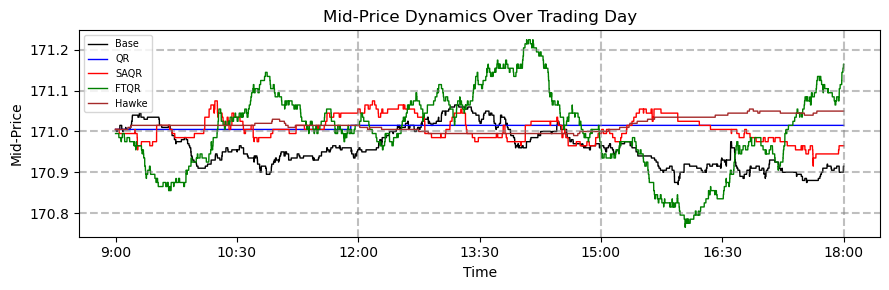

In [119]:
times = qr_data['time'].unique()
base_mid_prices = base_data['mid_price'].reindex(times, method='ffill')
qr_mid_prices = qr_data['mid_price'].reindex(times, method='ffill')
saqr_mid_prices = saqr_data['mid_price'].reindex(times, method='ffill')
ftqr_mid_prices = ftqr_data['mid_price'].reindex(times, method='ffill')
hawkes_mid_prices = hawkes_data['mid_price'].reindex(times, method='ffill')
hours = (times / 3600)

plt.figure(figsize=(9, 3))
plt.plot(hours, base_mid_prices, label='Base', color='black', linewidth=1)
plt.plot(hours, qr_mid_prices, label='QR', color='blue', linewidth=1)
plt.plot(hours, saqr_mid_prices, label='SAQR', color='red', linewidth=1)
plt.plot(hours, ftqr_mid_prices, label='FTQR', color='green', linewidth=1)
plt.plot(hours, hawkes_mid_prices, label='Hawke', color='brown', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend(prop={'size': 7})

time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.xticks(time_values, time_labels)
price_levels = [170.8, 170.9, 171.0, 171.1, 171.2]
plt.yticks(price_levels)

for price in price_levels:
    plt.axhline(y=price, color='gray', linestyle='--', alpha=0.5)
vertical_lines = [3, 6, 9]
for x in vertical_lines:
    plt.axvline(x=x, color='gray', linestyle='--', alpha=0.5)
    
plt.tight_layout()
#plt.savefig('results/images/simul_mid_price_dynamics.png')
plt.show()

## 2.Order Book shape

In [124]:
base_grouped = base_data.groupby(['side', 'level'])['queue_before'].mean()
qr_grouped = qr_data.groupby(['side', 'level'])['queue_before'].mean()
saqr_grouped = saqr_data.groupby(['side', 'level'])['queue_before'].mean()
ftqr_grouped = ftqr_data.groupby(['side', 'level'])['queue_before'].mean()

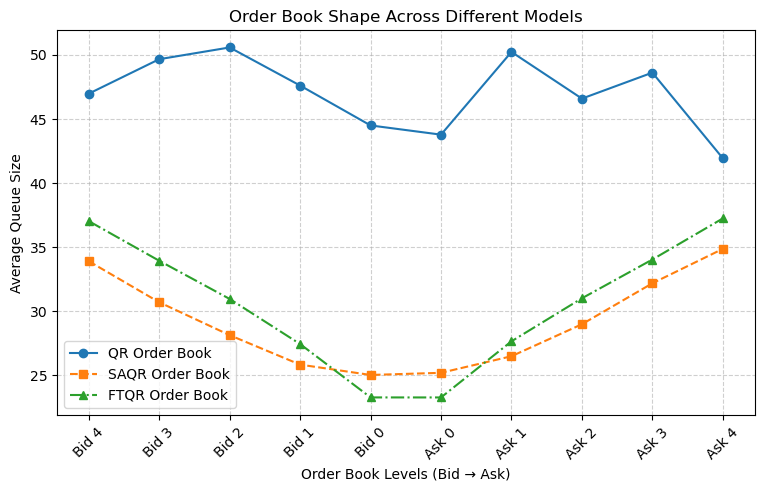

In [125]:
levels = sorted(qr_grouped.index.get_level_values('level').unique())
x_labels = [f'Bid {level}' for level in reversed(levels)] + [f'Ask {level}' for level in levels]

base_values = list(reversed(base_grouped.loc['bid'].values)) + list(base_grouped.loc['ask'].values)
qr_values = list(reversed(qr_grouped.loc['bid'].values)) + list(qr_grouped.loc['ask'].values)
saqr_values = list(reversed(saqr_grouped.loc['bid'].values)) + list(saqr_grouped.loc['ask'].values)
ftqr_values = list(reversed(ftqr_grouped.loc['bid'].values)) + list(ftqr_grouped.loc['ask'].values)

plt.figure(figsize=(9, 5))
#plt.plot(x_labels, base_values, label='Base Order Book', marker='*', linestyle='-')
plt.plot(x_labels, qr_values, label='QR Order Book', marker='o', linestyle='-')
plt.plot(x_labels, saqr_values, label='SAQR Order Book', marker='s', linestyle='--')
plt.plot(x_labels, ftqr_values, label='FTQR Order Book', marker='^', linestyle='-.')

plt.xlabel('Order Book Levels (Bid → Ask)')
plt.ylabel('Average Queue Size')
plt.title('Order Book Shape Across Different Models')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 3. Queue size distribution

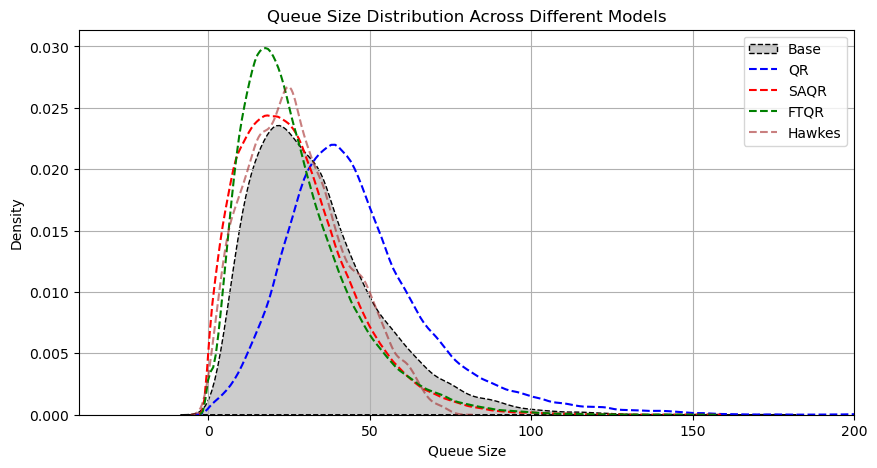

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

base_qsize = gamma.rvs(a=3, scale=11, size=10000)
sns.kdeplot(base_qsize, fill=True, color='black', alpha=0.2, label='Base', ls='--')
sns.kdeplot(qr_data['queue_before'], fill=False, color='blue', alpha=1, label='QR', ls='--')
sns.kdeplot(saqr_data['queue_before'], fill=False, color='red', alpha=1, label='SAQR', ls='--')
sns.kdeplot(ftqr_data['queue_before'], fill=False, color='green', alpha=1, label='FTQR', ls='--')
sns.kdeplot(hawkes_data['queue_before'], fill=False, color='brown', alpha=0.6, label='Hawkes', ls='--')

plt.xlim(-40, 200)
plt.xlabel('Queue Size')
plt.ylabel('Density')
plt.title('Queue Size Distribution Across Different Models')
plt.grid()
plt.legend()
plt.show()

## 4. Trading Volume

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

df1 = base_data.copy()
df2 = qr_data.copy()
df3 = saqr_data.copy()
df4 = ftqr_data.copy()
df5 = hawkes_data.copy()
for df in [df1, df2, df3, df4, df5]:
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)

base_sum_per_10min = df1['size'].resample('60min').sum()
qr_sum_per_10min = df2['size'].resample('60min').sum()
saqr_sum_per_10min = df3['size'].resample('60min').sum()
ftqr_sum_per_10min = df4['size'].resample('60min').sum()
hawkes_sum_per_10min = df5['size'].resample('60min').sum()

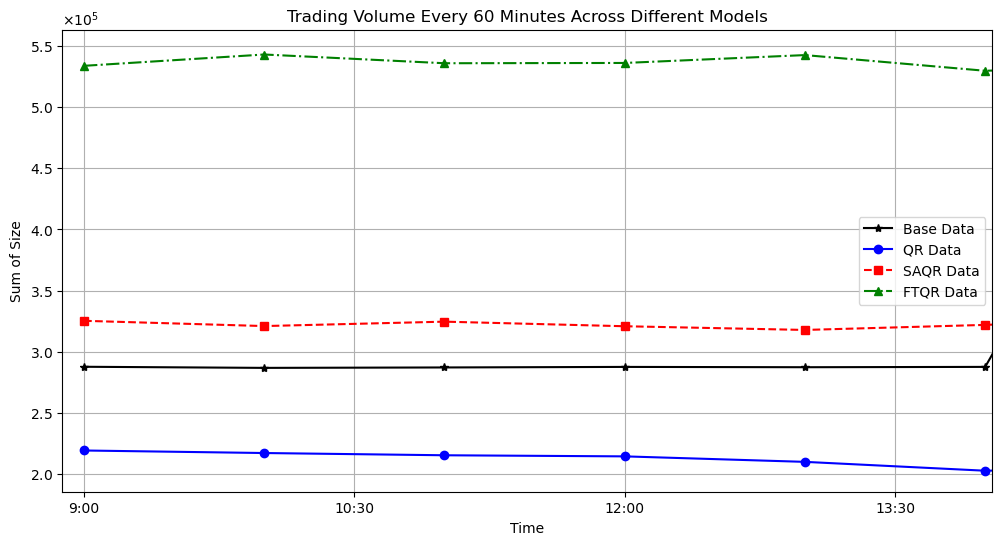

In [124]:
plt.figure(figsize=(12, 6))
plt.plot(base_sum_per_10min, marker='*', linestyle='-', label='Base Data', color='black')
plt.plot(qr_sum_per_10min, marker='o', linestyle='-', label='QR Data', color='blue')
plt.plot(saqr_sum_per_10min, marker='s', linestyle='--', label='SAQR Data', color='red')
plt.plot(ftqr_sum_per_10min, marker='^', linestyle='-.', label='FTQR Data', color='green')
plt.plot(hawkes_sum_per_10min, marker='^', linestyle='-.', label='Hawkes Data', color='brown')

time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9] # 小时数


time_ticks = [start_time + pd.Timedelta(hours=tv) for tv in time_values]

plt.xticks(time_ticks, time_labels)

plt.title('Trading Volume Every 60 Minutes Across Different Models')
plt.xlabel('Time')
plt.ylabel('Sum of Size')
plt.xlim(-0.005, 0.21)

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 

plt.grid(True)
plt.legend()
plt.show()

## 5. Volatility

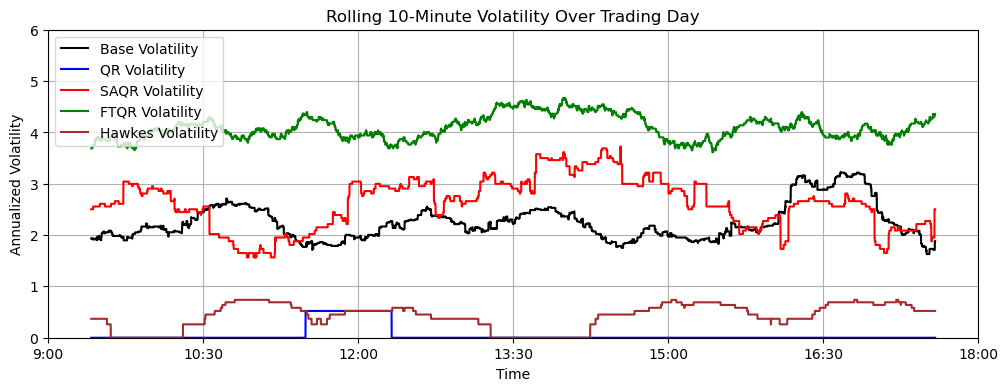

In [49]:
resampled_times = np.arange(0, TOTAL_TIME + 1, 1)
window_size = 3000  # 10分钟窗口

def compute_rolling_volatility(data):
    resampled_prices = data['mid_price'].reindex(resampled_times, method='ffill')

    rolling_volatility = []
    for i in range(0, len(resampled_times) - window_size + 1): 
        window_times = resampled_times[i:i + window_size]
        window_prices = resampled_prices[window_times]
        window_changes = np.diff(window_prices)
        if len(window_changes) > 0:
            vol = window_changes.std() * np.sqrt(252 * 32400)
            rolling_volatility.append((resampled_times[i + window_size // 2], vol))

    return pd.DataFrame(rolling_volatility, columns=['time', 'volatility'])

base_rolling_vol = compute_rolling_volatility(base_data)
qr_rolling_vol = compute_rolling_volatility(qr_data)
saqr_rolling_vol = compute_rolling_volatility(saqr_data)
ftqr_rolling_vol = compute_rolling_volatility(ftqr_data)
hawkes_rolling_vol = compute_rolling_volatility(hawkes_data)

plt.figure(figsize=(12, 4))
plt.plot(base_rolling_vol['time'] / 3600, base_rolling_vol['volatility'], label='Base Volatility', color='black')
plt.plot(qr_rolling_vol['time'] / 3600, qr_rolling_vol['volatility'], label='QR Volatility', color='blue')
plt.plot(saqr_rolling_vol['time'] / 3600, saqr_rolling_vol['volatility'], label='SAQR Volatility', color='red')
plt.plot(ftqr_rolling_vol['time'] / 3600, ftqr_rolling_vol['volatility'], label='FTQR Volatility', color='green')
plt.plot(hawkes_rolling_vol['time'] / 3600, hawkes_rolling_vol['volatility'], label='Hawkes Volatility', color='brown')

plt.xlabel('Time')
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.xticks(time_values, time_labels)
plt.ylabel('Annualized Volatility')
plt.ylim(0, 6)
plt.title('Rolling 10-Minute Volatility Over Trading Day')
plt.legend()
plt.grid(True)

plt.show()

# 6. Queue size over time

C:\Users\Nvve\AppData\Local\Temp\ipykernel_13728\3963576890.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'])
C:\Users\Nvve\AppData\Local\Temp\ipykernel_13728\3963576890.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['time'] = pd.to_datetime(df2['time'])


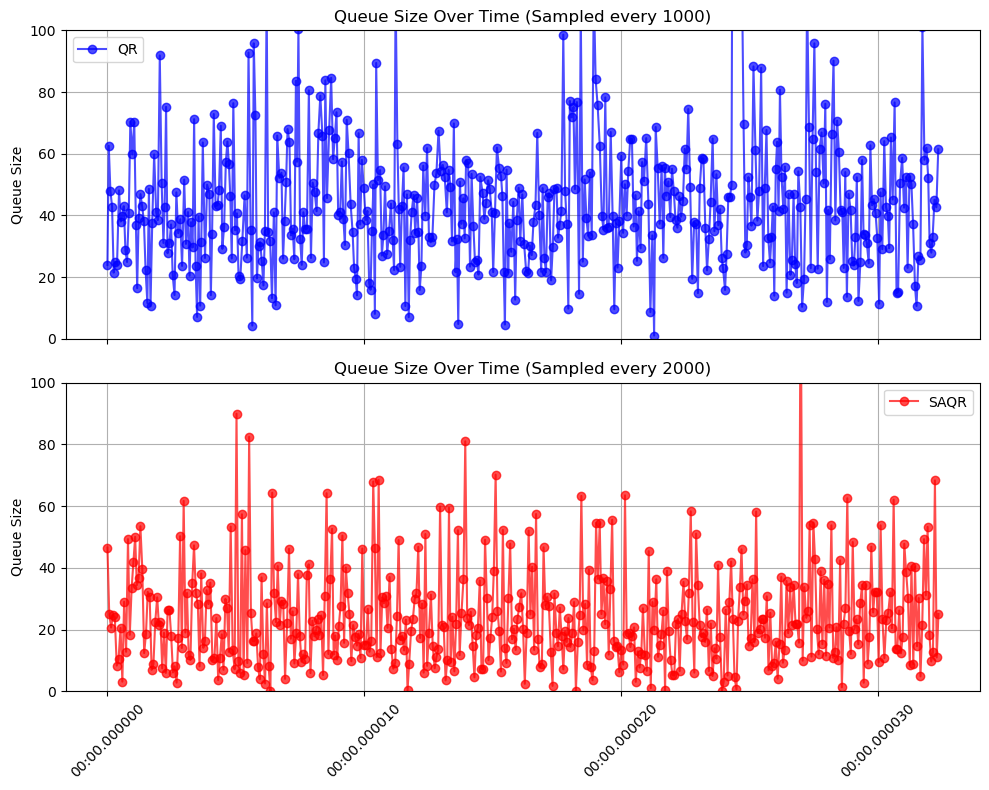

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

df_filtered1 = qr_data[(qr_data['side'] == 'bid') & (qr_data['level'] == 0)]
df1 = df_filtered1.iloc[::1000]

df_filtered2 = saqr_data[(saqr_data['side'] == 'bid') & (saqr_data['level'] == 0)]
df2 = df_filtered2.iloc[::2000]

df1['time'] = pd.to_datetime(df1['time'])
df2['time'] = pd.to_datetime(df2['time'])

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(df1['time'], df1['queue_before'], marker='o', linestyle='-', color='b', alpha=0.7, label='QR')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('Queue Size')
axes[0].set_title('Queue Size Over Time (Sampled every 1000)')
axes[0].legend()
axes[0].grid()

axes[1].plot(df2['time'], df2['queue_before'], marker='o', linestyle='-', color='r', alpha=0.7, label='SAQR')
axes[1].set_ylim(0, 100)
axes[1].set_ylabel('Queue Size')
axes[1].set_title('Queue Size Over Time (Sampled every 2000)')
axes[1].legend()
axes[1].grid()

plt.xticks(rotation=45)

# 调整子图间距
plt.tight_layout()

# 显示图像
plt.show()


# 7. Stats

In [113]:
stylized_stats = compute_stats(qr_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)

Stylized Facts Simulated Data Stats (Level 1-5):
                  #L        #C       #M       AES         AIT  Volatility
0           449633.0  439339.0  15562.0  1.000790   33.925395         NaN
1           239111.0  238969.0      0.0  0.999929   67.713213         NaN
2            95792.0   95232.0      0.0  1.002358  169.497501         NaN
3            72266.0   71701.0      0.0  1.000310  224.931322         NaN
4            72406.0   70236.0      0.0  1.001811  226.735303         NaN
Volatility       NaN       NaN      NaN       NaN         NaN    0.020667


In [120]:
stylized_stats = compute_stats(saqr_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)

Stylized Facts Simulated Data Stats (Level 1-5):
                   #L        #C       #M       AES         AIT  Volatility
0           1053888.0  910412.0  55110.0  1.507733   15.229778         NaN
1            554448.0  450049.0      0.0  1.432613   30.400495         NaN
2            221597.0  179360.0      0.0  1.430510   76.081455         NaN
3            167206.0  134916.0      0.0  1.420519  101.370371         NaN
4            167612.0  137669.0      0.0  1.432114  101.427237         NaN
Volatility        NaN       NaN      NaN       NaN         NaN    0.243019


In [114]:
stylized_stats = compute_stats(ftqr_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)

Stylized Facts Simulated Data Stats (Level 1-5):
                  #L        #C       #M       AES         AIT  Volatility
0           812428.0  715843.0  38023.0  1.969783   19.895621         NaN
1           425046.0  383405.0      0.0  0.996064   39.820745         NaN
2           168578.0  155508.0      0.0  0.996421   99.414940         NaN
3           125597.0  117453.0      0.0  0.998382  132.725802         NaN
4           124430.0  119663.0      0.0  0.998570  132.409373         NaN
Volatility       NaN       NaN      NaN       NaN         NaN    0.408918


In [115]:
stylized_stats = compute_stats(base_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)

Stylized Facts Simulated Data Stats (Level 1-5):
                  #L        #C       #M        AES         AIT  Volatility
0                0.0       0.0      0.0        NaN         NaN         NaN
1           421592.0  421340.0  93216.0  22.424645   34.609837         NaN
2           210537.0  210348.0  46511.0  22.439049   69.320033         NaN
3            84317.0   84194.0  18735.0  22.422593  173.032638         NaN
4            63147.0   63263.0  14103.0  22.456506  230.582073         NaN
Volatility       NaN       NaN      NaN        NaN         NaN    0.295712
